<a href="https://colab.research.google.com/github/ffreirea1988/usm/blob/main/Ayudant%C3%ADa_C2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [310]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as kr

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn import svm
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [6]:
#Datasets "de juguete" extraídos desde sklearn
from sklearn.datasets import load_breast_cancer

#Cargamos el diccionario de cancer desde sklearn:
df_array = load_breast_cancer()

In [11]:
X = df_array.data

In [17]:
X.shape

(569, 30)

In [311]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
Y = df_array.target

In [18]:
Y.shape

(569,)

In [55]:
columnas = df_array.feature_names

In [56]:
columnas

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [312]:
data = np.c_[X_scaled, Y]

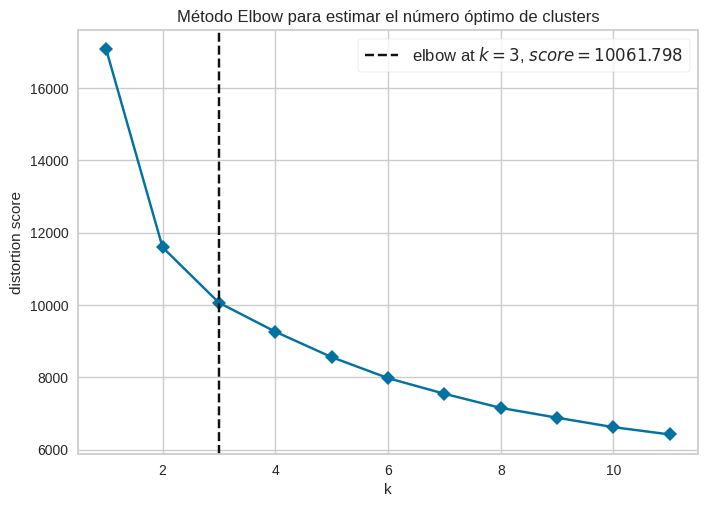

In [313]:
#Generamos el método Elbow para ver cuántos clusters generar en K-means
modelo = KMeans(random_state=1)

visualizer = KElbowVisualizer(
    modelo,
    k=(1,12),
    metric='distortion',
    title='Método Elbow para estimar el número óptimo de clusters',
    timings=False,
    locate_elbow=True,
    colors='coolwarm',
    show_metric=False
)

visualizer.fit(X_scaled)
visualizer.show()

plt.show()

In [314]:
# Aplicar K-Means con el número óptimo de clusters
kmeans = KMeans(n_clusters=3, max_iter=300, n_init=10, random_state=0)

#Obtener el cluster al que pertenecen los datos:
y_kmeans = kmeans.fit_predict(X_scaled)

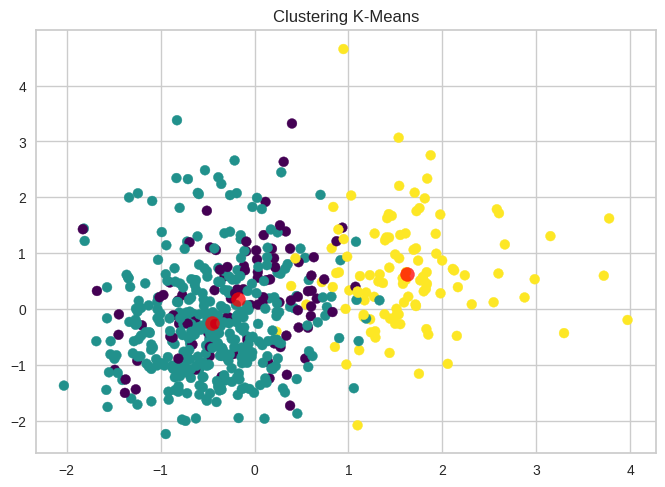

In [315]:
# Visualizar los clusters
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=100, alpha=0.75)
plt.title('Clustering K-Means')
plt.show()


In [316]:
# Por si necesitamos pasar a DataFrame las variables X
df = pd.DataFrame(X_scaled, columns=columnas)

#Agregamos el cluster de cada fila y la variable predictora
df['Cluster'] = y_kmeans
df['Y'] = Y

In [81]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,Cluster,Y
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1,0


In [82]:
df.shape

(569, 32)

In [84]:
# Para seleccionar solo los datos del primer clúster (Cluster 0) en el Dataframe
df_cluster_0 = df[df['Cluster'] == 0]

In [317]:
# Para seleccionar solo los datos del primer clúster (Cluster 0) en el Array
X_cluster_0 = X_scaled[y_kmeans == 0]
Y_cluster_0 = Y[y_kmeans == 0]

In [86]:
#Conocer la proporción de cada clase
df['Y'].value_counts()

Y
1    357
0    212
Name: count, dtype: int64

##Árboles de decisión##

In [318]:
# Separamos un 25% para testeo solo del cluster 0
X_train, X_test, Y_train, Y_test = train_test_split(X_cluster_0, Y_cluster_0, test_size=0.25)

In [319]:
# Instanciamos el modelo
#Definimos ccp_alpha como regularizador del modelo para que no caiga en overfitting:
#ccp_alpha entre 0 y 1 (entre más cercano a uno más castiga)
arbol = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=4, ccp_alpha=0.01)

#criterion: 'gini' o 'entropy'
#max_depth: máxima profundidad del árbol
#min_samples_leaf: mínima cantidad de muestras que quiero que queden luego de splitear
#min_samples_split: mínima cantidad de elementos para dividir

In [320]:
# Entrenamos el modelo
arbol.fit(X_train,Y_train)

DecisionTreeClassifier(ccp_alpha=0.01, max_depth=3, min_samples_leaf=4)

In [321]:
# veamos que tan bien le fue a este modelo en el testeo:
print(classification_report(y_true=Y_test,y_pred=arbol.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.92      1.00      0.96        11

    accuracy                           0.96        25
   macro avg       0.96      0.96      0.96        25
weighted avg       0.96      0.96      0.96        25



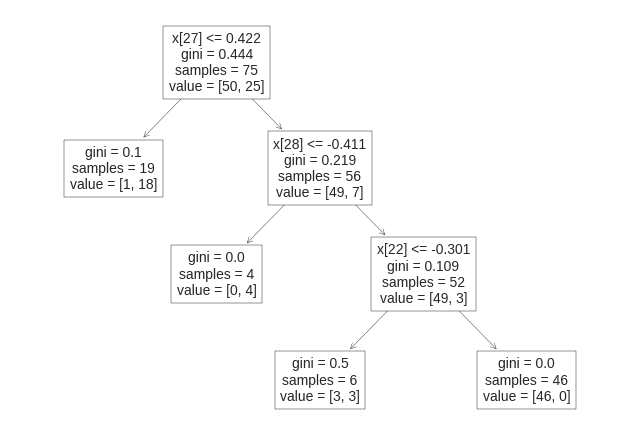

In [326]:
#Graficamos el árbol de decisión
plot_tree(arbol, fontsize=10)
plt.show()

In [327]:
#Generamos la predicción en el conjunto de testeo
Y_pred = arbol.predict(X_test)

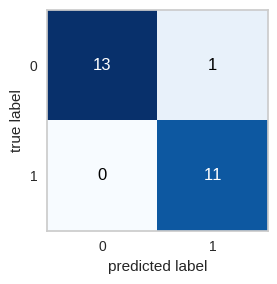

In [328]:
matriz = confusion_matrix(Y_test,Y_pred)

plot_confusion_matrix(conf_mat=matriz, figsize=(3,3), show_normed=False)
plt.tight_layout()

##SVM##

In [329]:
# Para seleccionar solo los datos del segundo clúster (Cluster 1) en el Array
X_cluster_1 = X_scaled[y_kmeans == 1]
Y_cluster_1 = Y[y_kmeans == 1]

In [330]:
# Separamos un 20% para testeo
X_train, X_test, Y_train, Y_test = train_test_split(X_cluster_1, Y_cluster_1, test_size=0.20)

In [331]:
#Instanciamos
sup_vector = svm.SVC(kernel='poly', C=0.75, random_state=200)

In [332]:
#Hacemos fit
sup_vector.fit(X_train, Y_train)

SVC(C=0.75, kernel='poly', random_state=200)

In [333]:
Y_pred = sup_vector.predict(X_test)

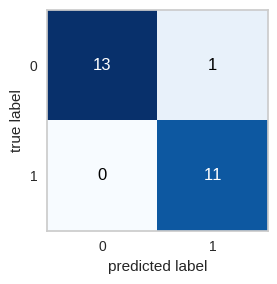

In [334]:
plot_confusion_matrix(conf_mat=matriz, figsize=(3,3), show_normed=False)
plt.tight_layout()

In [335]:
# veamos que tan bien le fue a este modelo en el testeo:
print(classification_report(y_true=Y_test,y_pred=Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.92      1.00      0.96        65

    accuracy                           0.92        72
   macro avg       0.96      0.57      0.60        72
weighted avg       0.92      0.92      0.89        72



##Redes Neuronales##

In [336]:
nn = [30, 15, 1]

In [337]:
model = kr.Sequential()

In [342]:
# Añadimos la capa 1

l0 = model.add(kr.layers.Dense(nn[0], activation='relu', input_shape=(X_train.shape[1],)))

l1 = model.add(kr.layers.Dense(nn[1], activation='relu'))

# Añadimos la capa 3
l3 = model.add(kr.layers.Dense(nn[2], activation='sigmoid'))

In [343]:
# Compilamos el modelo, definiendo la función de coste y el optimizador.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [345]:
# Separamos un 30% para testeo de todos los datos (independiente del cluster)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.30)

In [346]:
# Entrenamos al modelo para el tercer cluster
history = model.fit(X_train, Y_train, epochs=5, validation_data=(X_test, Y_test))

Epoch 1/5
13/13 [==============================] - 3s 21ms/step - loss: 0.6964 - acc: 0.4271 - val_loss: 0.6882 - val_acc: 0.6140
Epoch 2/5
13/13 [==============================] - 0s 5ms/step - loss: 0.6829 - acc: 0.6332 - val_loss: 0.6805 - val_acc: 0.6140
Epoch 3/5
13/13 [==============================] - 0s 5ms/step - loss: 0.6753 - acc: 0.6332 - val_loss: 0.6748 - val_acc: 0.6140
Epoch 4/5
13/13 [==============================] - 0s 5ms/step - loss: 0.6679 - acc: 0.6332 - val_loss: 0.6706 - val_acc: 0.6140
Epoch 5/5
13/13 [==============================] - 0s 6ms/step - loss: 0.6628 - acc: 0.6332 - val_loss: 0.6679 - val_acc: 0.6140


In [347]:
# Obtener predicciones
Y_pred = model.predict(X_test)
Y_pred_classes = (Y_pred > 0.5).astype("int32")

6/6 [==============================] - 0s 2ms/step


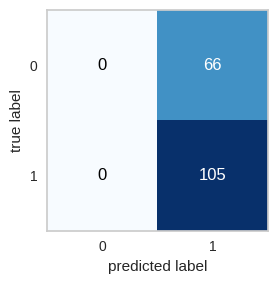

In [348]:
matriz = confusion_matrix(Y_test,Y_pred_classes)

plot_confusion_matrix(conf_mat=matriz, figsize=(3,3), show_normed=False)
plt.tight_layout()

In [309]:
# veamos que tan bien le fue a este modelo en el testeo:
print(classification_report(y_true=Y_test,y_pred=Y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        67
           1       0.61      1.00      0.76       104

    accuracy                           0.61       171
   macro avg       0.30      0.50      0.38       171
weighted avg       0.37      0.61      0.46       171



¿Qué ocurre en la red neuronal que predice todo como 1?